http://modflowpy.github.io/flopydoc/tutorial1.html

## Run the tutorial

In [44]:
import os
import flopy
import numpy as np
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
from hyvr import hyvr_utils as hu


In [ ]:
# Assign name and create modflow model object
modelname = 'tutorial1'
mf = flopy.modflow.Modflow(modelname, exe_name='mf2005')

# Model domain and grid definition
Lx = 1000.
Ly = 1000.
ztop = 0.
zbot = -50.
nlay = 1
nrow = 10
ncol = 10
delr = Lx/ncol
delc = Ly/nrow
delv = (ztop - zbot) / nlay
botm = np.linspace(ztop, zbot, nlay + 1)

# Create the discretization object
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, top=ztop, botm=botm[1:])

In [ ]:
# Variables for the BAS package
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:, :, 0] = 10.
strt[:, :, -1] = 0.
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

# Add LPF package to the MODFLOW model
lpf = flopy.modflow.ModflowLpf(mf, hk=10., vka=10.)

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(mf)

# Add PCG package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(mf)

# Write the MODFLOW model input files
mf.write_input()

In [ ]:
# Run the MODFLOW model
success, buff = mf.run_model()

In [ ]:

plt.subplot(1,1,1,aspect='equal')
hds = bf.HeadFile(modelname+'.hds')
head = hds.get_data(totim=1.0)
levels = np.arange(1,10,1)
extent = (delr/2., Lx - delr/2., Ly - delc/2., delc/2.)
plt.contour(head[0, :, :], levels=levels, extent=extent)
plt.show()

## Try with HYVR data

In [40]:
# Load parameters and HYVR simulations
param_file = 'E:/repositories/hfm_flowtrans/runfiles/flowtrans_test/flowtrans_diptest/flowtrans_diptest_parameters.ini'
run, model, _, _, flowtrans, _, mg = hu.model_setup(param_file)

hyvr_fp = 'E:/repositories/hfm_flowtrans/runfiles/flowtrans_test/flowtrans_diptest/flowtrans_diptest.npz'
ho = np.load(hyvr_fp)

In [45]:
# Assign name and create modflow model object
# Create modflow output folder
mfdir = run['modeldir'] + '/' + run['runname']  + '/modflow'
try:
    os.makedirs(mfdir)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise


mf = flopy.modflow.Modflow(mfdir + run['runname'], exe_name='mf2005')

# Model domain and grid definition
Lx = mg.lx
Ly = mg.ly
ztop = mg.oz + mg.lz
zbot = mg.oz
nlay = mg.nz
nrow = mg.nx
ncol = mg.ny
delr = Lx/ncol
delc = Ly/nrow
delv = (ztop - zbot) / nlay
botm = np.linspace(ztop, zbot, nlay + 1)

# Create the discretization object
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, top=ztop, botm=botm[1:])

In [46]:
# Variables for the BAS package
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1

strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:, :, 0] = flowtrans['hin'][0]
strt[:, :, -1] = flowtrans['hout'][0]

bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

# Assign hydraulic conductivity
hyvr_hk = np.transpose(ho['k_iso'], (2, 0, 1))
hyvr_layvka = 1                                           # VKA dataset is ratio of horizontal K
hyvr_vka = np.transpose(ho['anirat'], (2, 0, 1))

# Add LPF package to the MODFLOW model
lpf = flopy.modflow.ModflowLpf(mf,                        # Modflow object
                               hk = hyvr_hk,              # Horizontal hydraulic conductivity
                               layvka = hyvr_layvka,      # Flag for each layer of anisotropic ratio
                               vka = hyvr_vka)            # Anisotropy ratios.
                            
# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(mf)

# Add PCG package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(mf)

# Write the MODFLOW model input files
mf.write_input()

In [28]:
# Run the MODFLOW model
success, buff = mf.run_model()

FloPy is using the following executable to run the model: C:\Program Files (x86)\MF2005.1_12\bin\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: HYVRtest.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2017/11/20 16:35:14

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2017/11/20 16:35:15
 Elapsed run time:  0.575 Seconds

  Normal termination of simulation


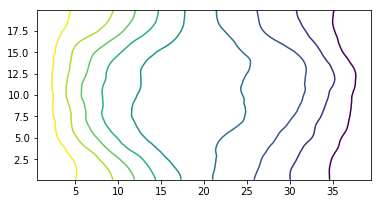

In [34]:
plt.subplot(1,1,1,aspect='equal')
hds = bf.HeadFile(modelname+'.hds')
head = hds.get_data(totim=1.0)
levels = np.arange(0,1,0.1)
extent = (delr/2., Lx - delr/2., Ly - delc/2., delc/2.)
plt.contour(head[0, :, :], levels=levels, extent=extent)
plt.show()

In [42]:
run['modeldir'] + '/' + run['runname'] + '/modflow'

'E:/repositories/hfm_flowtrans/runfiles/flowtrans_test/flowtrans_diptest/flowtrans_diptest/modflow'